# Temporal Difference Learning Model for Dopamine Signals in PMA Task

This notebook models dopamine signals in a Platform Mediated Avoidance (PMA) task using a Temporal Difference (TD) learning framework.

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
from tqdm import tqdm
    

### File Path and Data Loading

In [4]:

file_path = r"C:\Users\boba4\Documents\GitHub\ucla_analysis\DAPL\data\PMA\DP066_PMA_allTrials.csv"
dopamine_signals = pd.read_csv(file_path, header=None)
dopamine_signals = np.array(dopamine_signals)

shock_ranges = [(1650, 1800)]
    

### Helper Functions

In [5]:

def create_shocks_array(length, ranges):
    shocks = np.zeros(length)
    for start, end in ranges:
        shocks[start:end+1] = 1
    return shocks

def value_function(t, params):
    return params[0] * t + params[1]

def td_error(t, params, shocks, gamma, alpha):
    V_t = value_function(t, params)
    V_t1 = value_function(t + 1, params)
    td_error = shocks[t] + gamma * V_t1 - V_t
    return V_t + alpha * td_error
    

### Model Fitting

Fitting model to trials:  85%|████████▌ | 23/27 [00:47<00:08,  2.05s/it]


KeyboardInterrupt: 

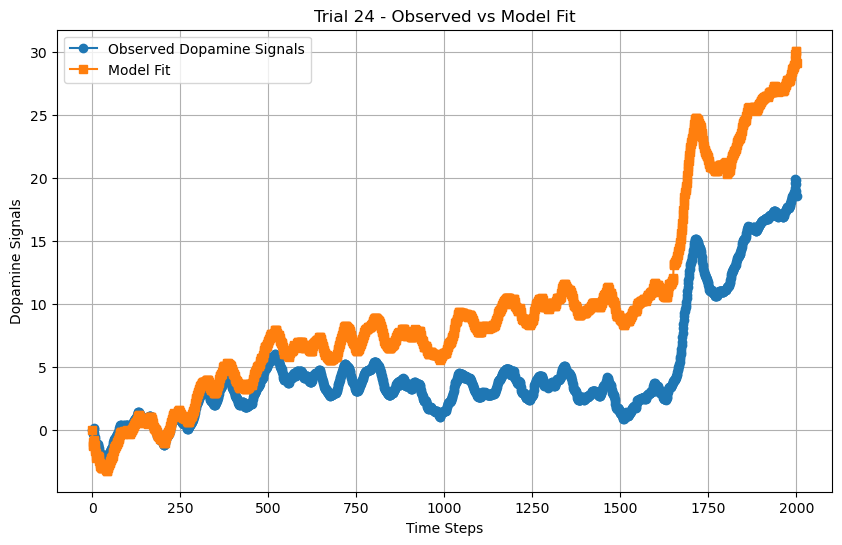

In [9]:

num_trials = dopamine_signals.shape[0]
time_steps = np.arange(dopamine_signals.shape[1])

all_time_coeffs = []
all_baseline_values = []
all_gammas = []
all_alphas = []
all_observed_signals = []
all_predicted_signals = []
all_signals = []

sheet_name = os.path.basename(file_path).split('.')[0]
plot_dir = os.path.join(os.path.dirname(file_path), sheet_name, 'trial_fit_plots_TD_perTrial')
os.makedirs(plot_dir, exist_ok=True)

for trial in tqdm(range(num_trials), desc="Fitting model to trials"):
    average_DA_signal = dopamine_signals[trial, :]
    shocks = create_shocks_array(len(average_DA_signal), shock_ranges)

    def likelihood(params):
        params_without_gamma_alpha = params[:-2]
        gamma = params[-2]
        alpha = params[-1]
        errors = np.array([
            td_error(t, params_without_gamma_alpha, shocks, gamma, alpha) 
            for t in time_steps[:-1]
        ])
        likelihoods = -0.5 * np.sum((average_DA_signal[1:] - errors) ** 2)
        return -likelihoods

    initial_params = np.array([0.1, 0.1, 0.3, 0.5])
    bounds = [(None, None), (None, None), (0, 1), (0, 1)]

    result = minimize(likelihood, initial_params, method='L-BFGS-B', bounds=bounds)
    optimal_params = result.x

    all_time_coeffs.append(optimal_params[0])
    all_baseline_values.append(optimal_params[1])
    all_gammas.append(optimal_params[2])
    all_alphas.append(optimal_params[3])

    predicted_signals = np.zeros_like(average_DA_signal)
    predicted_signals[0] = average_DA_signal[0]
    for t in range(len(average_DA_signal) - 1):
        predicted_signals[t + 1] = (
            td_error(t, optimal_params[:-2], shocks, optimal_params[-2], optimal_params[-1]) 
            + average_DA_signal[t]
        )

    all_observed_signals.append(average_DA_signal)
    all_predicted_signals.append(predicted_signals)

    for time_step in range(len(average_DA_signal)):
        all_signals.append([trial + 1, time_step, average_DA_signal[time_step], predicted_signals[time_step]])

    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, average_DA_signal, 'o-', label='Observed Dopamine Signals')
    plt.plot(time_steps, predicted_signals, 's-', label='Model Fit')
    plt.xlabel('Time Steps')
    plt.ylabel('Dopamine Signals')
    plt.title(f'Trial {trial + 1} - Observed vs Model Fit')
    plt.legend()
    plt.grid(True)

    trial_plot_file = os.path.join(plot_dir, f"trial_{trial + 1}_fit.png")
    plt.savefig(trial_plot_file, transparent=True, dpi=600)
    plt.close()
    

### Save Results to Excel

In [ ]:

signals_df = pd.DataFrame(all_signals, columns=['Trial', 'Time Step', 'Observed Dopamine', 'Predicted Dopamine'])

excel_file_path = r"C:\Users\tgupt\Downloads\PMA for TG_v2_20240701\PMA_parameters_AllTrials_TD_perTrial_v2.xlsx"
params_df = pd.DataFrame({
    'Trial': np.arange(1, num_trials + 1),
    'Time Coefficient (params[0])': all_time_coeffs,
    'Baseline Value (params[1])': all_baseline_values,
    'Gamma': all_gammas,
    'Alpha': all_alphas
})

if os.path.exists(excel_file_path):
    with pd.ExcelWriter(excel_file_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        params_df.to_excel(writer, sheet_name=f"{sheet_name}_Params", index=False)
        signals_df.to_excel(writer, sheet_name=f"{sheet_name}_DA Signals", index=False)
else:
    with pd.ExcelWriter(excel_file_path, mode='w', engine='openpyxl') as writer:
        params_df.to_excel(writer, sheet_name=f"{sheet_name}_Params", index=False)
        signals_df.to_excel(writer, sheet_name=f"{sheet_name}_DA Signals", index=False)
    